In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
'''
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import albumentations as A
'''
%matplotlib inline

In [ ]:
def model_and_predict(image):
    # Backbone & preprocess
    BACKBONE = 'seresnet152'
    #preprocess_input = sm.get_preprocessing(BACKBONE)
    
    # build model
    loss = sm.losses.bce_jaccard_loss
    metrics = sm.metrics.FScore()
    model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    model.compile('Adam', loss=loss, metrics=[metrics])
    model.load_weights('seresnet152_gen_roof_all.h5')

    # read image
    test_img = cv2.imread('dongjak.jpg', cv2.IMREAD_COLOR)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
    #plt.imshow(test_img, cmap='gray')
    test_img = np.expand_dims(test_img, axis=0)

    # predict image
    prediction = model.predict(test_img)
    prediction_image = prediction.reshape(512,512,1)
    prediction_image = prediction_image > 0.5
    prediction_image = prediction_image * 255.
    #plt.imshow(prediction_image, cmap='gray')
    return prediction_image

In [13]:
image_pth = 'dongjak.jpg'
mask_pth = 'dongjak_mask.jpg'

In [14]:
def mouse_crop(image_pth, mask_pth):
    # get image and mask
    # use mouse to crop ROI
    # save the cropped ROI for image and mask
    
    # mouse event
    img = cv2.imread(image_pth)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_pth)
    img2 = img.copy()
    # variables
    ix = -1
    iy = -1
    drawing = False

    x1=0
    x2=0
    y1=0
    y2=0
    
    def draw_rectangle_with_drag(event, x, y, flags, param):
        nonlocal ix, iy, drawing, img, x1,x2,y1,y2
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix = x
            iy = y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing == True:
                img2 = cv2.imread(image_pth)
                cv2.rectangle(img2, pt1=(ix,iy), pt2=(x, y),color=(0,200,255),thickness=3)
                img = img2

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            img2 = cv2.imread(image_pth)
            cv2.rectangle(img2, pt1=(ix,iy), pt2=(x, y),color=(0,200,255),thickness=3)
            img = img2
            x1,x2,y1,y2 = ix, x, iy, y

    cv2.namedWindow(winname= "Use your mouse to select a ROI")
    cv2.setMouseCallback("Use your mouse to select a ROI", draw_rectangle_with_drag)

    while True:
        cv2.imshow("Use your mouse to select a ROI", img)
        k = cv2.waitKey(1)
        if k == 13: # 13 = Enter
            break
            
        elif k == 27: # 27 = Esc
            break
            
    cv2.destroyAllWindows()

    print('x1 = {}\nx2 = {}\ny1 = {}\ny2 = {}'.format(x1,x2,y1,y2))

    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB) # for matplotlib
    
    img_crop = img2[y1-1:y2+1, x1-1:x2+1]
    mask_crop = mask[y1-1:y2+1, x1-1:x2+1]
    
    fig = plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_crop)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(mask_crop)
    plt.show()
    return img_crop, mask_crop

x1 = 0
x2 = 0
y1 = 0
y2 = 0


ValueError: zero-size array to reduction operation minimum which has no identity

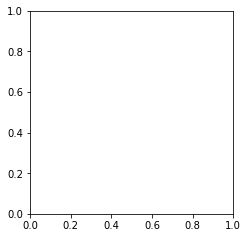

In [15]:
img_crop, mask_crop = mouse_crop(image_pth, mask_pth)

mask_crop = mask_clean(mask_crop)
plt.imshow(mask_crop)

img_cropped, mask_cropped = crop_one_building(img_crop, mask_crop)

mask_cropped = DP_method(mask_cropped)

visualize(img_cropped, mask_cropped)

solar_panel(img_cropped, mask_cropped)

In [7]:
def mask_clean(mask_crop):
    # flood
    img = mask_crop
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    h, w = thresh.shape[:2]
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    holes = cv2.floodFill(thresh.copy(), mask, (0, 0), 255)[1]
    holes = ~holes
    thresh[holes == 255] = 255

    # close opening
    img = cv2.erode(thresh,(3,3),iterations=3)
    img = cv2.dilate(img,(3,3),iterations=3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    (thresh, binRed) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    plt.figure(figsize=(8,8))
    plt.imshow(opening, cmap='gray')
    return mask_crop

In [ ]:
mask_crop = mask_clean(mask_crop)
plt.imshow(mask_crop)

In [8]:
def crop_one_building(img_crop, mask_crop):
    # from the ROI we crop the largest contour assuming it to be the building we want to predict
    
    image = img_crop  
    mask = mask_crop
    mask2= mask.copy()
    
    gray_image = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # Apply cv2.threshold() to get a binary image
    ret, thresh = cv2.threshold(gray_image, 100, 255, 0)
    
    # Find contours:
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cnts = []
    #for c in contours:
    #    x,y,w,h = cv2.boundingRect(c)
    #    if not (w < 10 or h < 10): 
    #        cnts.append(c)
    #print(contours)
    
    max_value = max(contours, key = len)
    max_index = contours.index(max_value)
    #print(max_index)
    cv2.drawContours(mask2, contours, max_index, (100, 255, 255), -1)

    x, y = [], []
    for contour in contours[max_index]:
        x.append(contour[0][0])
        y.append(contour[0][1])

    x1, x2, y1, y2 = min(x), max(x), min(y), max(y)
    img_cropped = image[y1-2:y2+2, x1-2:x2+2]
    mask_cropped= mask[y1-2:y2+2, x1-2:x2+2]
    
    fig = plt.figure(figsize=(8, 8))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_cropped)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(mask_cropped)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mask2)
    plt.show()
    return img_cropped, mask_cropped

In [ ]:
img_cropped, mask_cropped = crop_one_building(img_crop, mask_crop)

In [9]:
def DP_method(mask_cropped):
    # use DP method onto the mask
    # maybe find corners first and if they are below a certain number use DP
    # because it is useful for rectanglur images rather than polygons ?
    # https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv
    # DP METHOD
    mask = mask_cropped
    #img = img_cropped
    mask_zero = np.zeros(mask.shape, np.uint8)

    gray_image = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Apply cv2.threshold() to get a binary image
    ret, thresh = cv2.threshold(gray_image, 100, 255, 0)

    # Find contours:
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = []

    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if not (w < 10 or h < 10): 
            cnts.append(c)

    for i in range(len(cnts)):
        epsilon = 0.02*cv2.arcLength(cnts[i], True)
        approx = cv2.approxPolyDP(cnts[i], epsilon, True)
        vtc = len(approx)
        print(vtc)

        if vtc <= 8:
            cv2.drawContours(mask_zero, [approx], 0, (255, 255, 255), -1)
        else:
            cv2.drawContours(mask_zero, cnts, i, (255, 255, 255), -1)

    cv2.imshow('contour', mask_zero)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    plt.imshow(mask_zero)
    return mask_zero

In [ ]:
mask_cropped = DP_method(mask_cropped)

In [10]:
def visualize(img_cropped, mask_cropped):
    test_img = img_cropped
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    gray_img = mask_cropped
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(test_img, 'gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(test_img, 'gray', interpolation='none')
    plt.imshow(gray_img, 'Set3', interpolation='none', alpha=0.5) # jet / ocean / gist_earth / terrain
    # matplotlib.org/stable/tutorials/colors/colormaps.html - See colormaps
    
    plt.show()

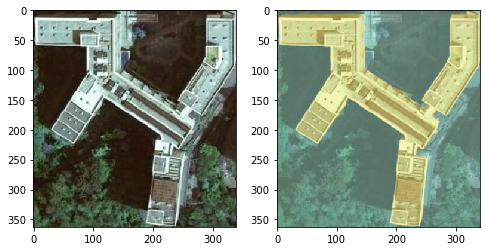

In [128]:
visualize(img_cropped, mask_cropped)

In [11]:
def solar_panel(img_cropped, mask_cropped):
    # draw rectangles on building and visualize
    # from the number of panels get the ammount of potential energy
    image = img_cropped
    image2 = image.copy()
    mask = mask_cropped
    mask2 = mask.copy()
    ret, thresh = cv2.threshold(mask2, 100, 255, 0)
    mask2 = thresh

    number = 0

    for i in range(mask.shape[1]//5): # x
        for j in range(mask.shape[0]//10): # y
            start = (i*5, j*10) # x y
            end = ((i+1)*5, (j+1)*10) # x y
            if (mask2[j*10:(j+1)*10, i*5:(i+1)*5] != 0).all():
                cv2.rectangle(mask2, start, end, (100,100,100), 1)
                cv2.rectangle(mask2, (i*5+1, j*10+1),((i+1)*5-1, (j+1)*10-1), (200,255,255), -1)
                
                cv2.rectangle(image2, start, end, (100,100,100), 1)
                cv2.rectangle(image2, (i*5+1, j*10+1),((i+1)*5-1, (j+1)*10-1), (200,255,255), -1)
                number += 1

    for i in range(mask.shape[0]//5):
        for j in range(mask.shape[1]//10):
            start = (j*10, i*5)
            end = ((j+1)*10, (i+1)*5)
            if ((mask2[i*5:(i+1)*5, j*10:(j+1)*10] != 0).all()) and ((mask2[i*5:(i+1)*5, j*10:(j+1)*10] != 100).all()):
                cv2.rectangle(mask2, start, end, (101,101,101), 1)
                cv2.rectangle(mask2, (j*10+1, i*5+1), ((j+1)*10-1, (i+1)*5-1), (200,255,255), -1)
                
                cv2.rectangle(image2, start, end, (101,101,101), 1)
                cv2.rectangle(image2, (j*10+1, i*5+1), ((j+1)*10-1, (i+1)*5-1), (200,255,255), -1)
                number +=1

    print(number)
    plt.figure(figsize=(8,8))
    plt.imshow(mask2)
    
    #plt.figure(figsize=(12,12))
    #plt.subplot(1,2,1)
    #plt.imshow(image, 'gray', interpolation='none')
    #plt.subplot(1,2,2)
    #plt.imshow(image, 'gray', interpolation='none')
    #plt.imshow(mask2, 'Set3', interpolation='none', alpha=0.5)
    
    # 1. the area of the building using countNonZero
    # 2. number of panels x Pn x Pv = solar potential
    # 3. (think)
    
    #ret,thresh=cv2.threshold(img,133,255,cv2.THRESH_BINARY_INV)
    
    #img = cv2.imread("Crop_out_white.jpg",0)
    #ret, thresh = cv2.threshold(img, 100, 255, 0)
    #pixel=cv2.countNonZero(thresh)
    #print(img.shape[0]*img.shape[1])
    
    #pixel
    #one_pixel = 173.312/1433
    #one_pixel
    #area = pixel*10 #m^2
    #solar_potential=Panel*Pn*PV #Pn=kw,태양광 패널의 공칭 용량 / PV=kWh,kWp 출력

694


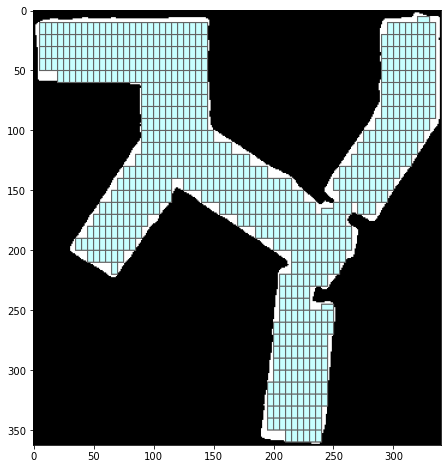

In [170]:
solar_panel(img_cropped, mask_cropped)

x1 = 161
x2 = 231
y1 = 239
y2 = 327


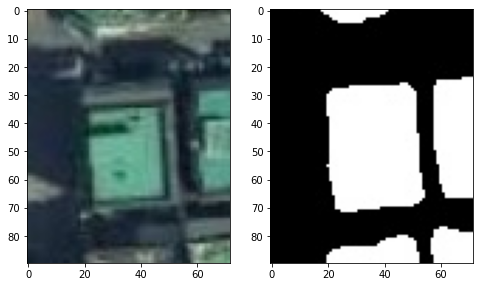

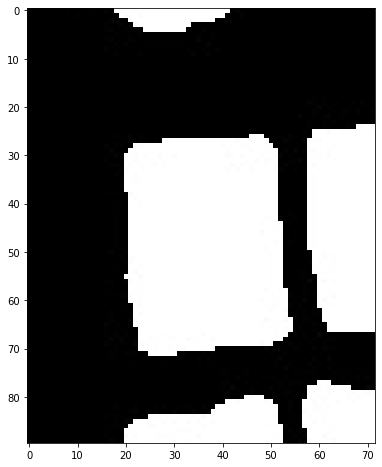

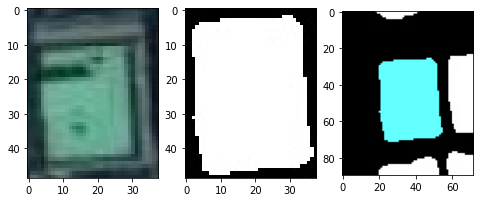

4


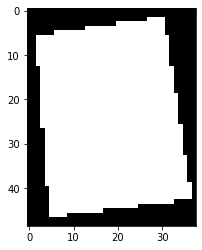

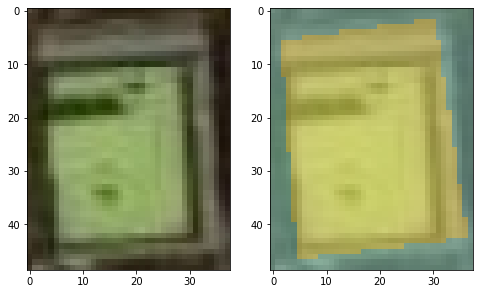

18


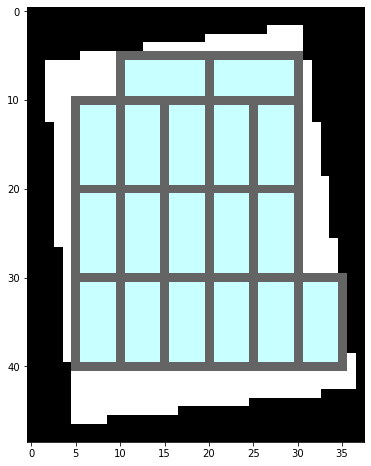

In [12]:
img_crop, mask_crop = mouse_crop(image_pth, mask_pth)

mask_crop = mask_clean(mask_crop)
plt.imshow(mask_crop)

img_cropped, mask_cropped = crop_one_building(img_crop, mask_crop)

mask_cropped = DP_method(mask_cropped)

visualize(img_cropped, mask_cropped)

solar_panel(img_cropped, mask_cropped)